## Fake Review Detector using LSTM
#### Import nescessary libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import gensim

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense,  Embedding, LSTM

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import pickle

import acessory_func as af

import warnings
warnings.filterwarnings('ignore')

plt.style.use('dark_background')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\andy\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\andy\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\andy\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\andy\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     C:\Users\andy\AppData\Roaming\nltk_data...
[nltk_data]    |   Pac

#### Data Cleaning and Preprocessing

In [2]:
# Read the dataset with columns 'text_' and 'label' only
df = pd.read_csv('../dataset/fake reviews dataset.csv', usecols=['text_','label'])
df.head()

,label,text_
0,CG,"Love this! Well made, sturdy, and very comfor..."
1,CG,"love it, a great upgrade from the original. I..."
2,CG,This pillow saved my back. I love the look and...
3,CG,"Missing information on how to use it, but it i..."
4,CG,Very nice set. Good quality. We have had the s...


In [3]:
# Use the function from acessory_func.py to clean the text
# Remove the URLs from the text
df['clean_text'] = af.remove_url(df['text_'])

# Convert the text to lower case and remove numbers, punctuation, and stopwords
# Keep apostrophe "'" to keep words that are contractions in the text
# Keep "not" and "didn't" in the text
df['clean_text'] = af.cleaning(df['clean_text'], stopwords_to_exclude=['not', "didn't"], punc_to_exclude="'")

# Tokenize and Lemmatize the text
df['clean_text'] = af.preprocessing(df['clean_text'], lemma=True)

df.head()

,label,text_,clean_text
0,CG,"Love this! Well made, sturdy, and very comfor...","[love, well, make, sturdy, comfortable, love, ..."
1,CG,"love it, a great upgrade from the original. I...","[love, great, upgrade, original, i've, mine, c..."
2,CG,This pillow saved my back. I love the look and...,"[pillow, save, back, love, look, feel, pillow]"
3,CG,"Missing information on how to use it, but it i...","[miss, information, use, great, product, price]"
4,CG,Very nice set. Good quality. We have had the s...,"[nice, set, good, quality, set, two, month, not]"


#### Word Embedding using pretrained Word2Vec

We will first load the pretrained Word2Vec model created by Google.

In [4]:
# Load the pre-trained word2vec model
google_vec_file = '../dataset/GoogleNews-vectors-negative300.bin.gz'
google_model = gensim.models.KeyedVectors.load_word2vec_format(google_vec_file, binary=True)

In [5]:
# Prepare the dataset
X = df['clean_text']

# Encode the labels to 1 and 0
y = df['label'].map({'OR': 1, 'CG': 0})

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Before converting the text data into dense vectors for model training, we will use **Tokenizer Class from keras library** to get a list of vocaburary used in the text data. Each word in the vocaburary will be assign a number and we will map the word to the Word2Vec model to get the dense vector representing the word.

In [6]:
# Tokenize the text to get a list of vocaburary assign with numbers
em_word_tokenizer = Tokenizer()
em_word_tokenizer.fit_on_texts(X_train)

# Encode the words in the text data with the numbers assigned to them
X_train = em_word_tokenizer.texts_to_sequences(X_train)
X_test = em_word_tokenizer.texts_to_sequences(X_test)

In [7]:
# Display first 5 key-value pair of the words and their assigned numbers
{k: em_word_tokenizer.word_index[k] for k in list(em_word_tokenizer.word_index)[:5]}

{'not': 1, 'love': 2, 'book': 3, 'great': 4, 'good': 5}

We need to **add 1** to the vocaburary lenght because the numbers used to assign to the words start from 1 not 0 as shown.

In [8]:
# Add 1 to the lenght of the vocaburary
vocab_length = len(em_word_tokenizer.word_index) + 1

vocab_length

28829

For using LSTM, we need the input data to have the same shape and size. Reviews have different length. To make all input reviews in our text data to be the same length, **padding** technique will be used to add 0 at the end of each review that are shorter to match the length of the longest review.

We will not use the length of the longest review in our text data to reduce the computational resources required. This will also reduce the noise produce due to excessive padding.

We first take a look at the words distribution of each review in our text data to select max length for each review.

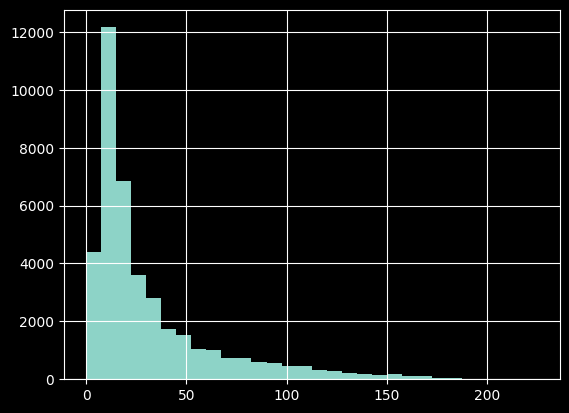

In [9]:
# Plot a histogram to see the distribution of the review length
seq_len = [len(i) for i in df['clean_text']]

pd.Series(seq_len).hist(bins = 30);

Most reviews are having around 50 words. We will set the review length to 60. This means that 0 will be added to review length that are shorter than 60. For review length that are longer than 60, the rest of the words will be cut off.

In [10]:
# Set the maximum length of the review
maxlen = 60

# Pad reviews to have the same length
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen, truncating='post')
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen, truncating='post')

Now we have the reviews in the same length, we will use the Word2Vec model to get the dense vector representing each word.

In [11]:
# Get the dense vector representation of the words
embedding_matrix = np.zeros((vocab_length, 300))
for word, index in em_word_tokenizer.word_index.items():
    
    # ignore words that are not in Word2Vec model
    try:
        if google_model[word] is not None:
            embedding_vector = google_model[word]
            embedding_matrix[index] = embedding_vector
    except:
        continue

We are ready to build and train the LSTM model.

#### Model Training

In [12]:
np.random.seed(42)

# Create the LSTM model
lstm_model_1 = Sequential()
embedding_layer = Embedding(vocab_length, 300, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model_1.add(embedding_layer)
lstm_model_1.add(LSTM(128))
lstm_model_1.add(Dense(1, activation='sigmoid'))

In [13]:
# Compile the model
lstm_model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model_1.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 300)           8648700   
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 8868477 (33.83 MB)
Trainable params: 219777 (858.50 KB)
Non-trainable params: 8648700 (32.99 MB)
_________________________________________________________________
None


In [14]:
# Train the model
lstm_model_1_history = lstm_model_1.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6


177/177 [==============================] - 36s 189ms/step - loss: 0.5153 - acc: 0.7366 - val_loss: 0.4889 - val_acc: 0.7700
Epoch 2/6
177/177 [==============================] - 33s 186ms/step - loss: 0.4119 - acc: 0.8110 - val_loss: 0.3845 - val_acc: 0.8205
Epoch 3/6
177/177 [==============================] - 32s 182ms/step - loss: 0.3537 - acc: 0.8390 - val_loss: 0.3534 - val_acc: 0.8431
Epoch 4/6
177/177 [==============================] - 29s 165ms/step - loss: 0.3301 - acc: 0.8531 - val_loss: 0.3344 - val_acc: 0.8513
Epoch 5/6
177/177 [==============================] - 31s 175ms/step - loss: 0.3034 - acc: 0.8652 - val_loss: 0.3206 - val_acc: 0.8633
Epoch 6/6
177/177 [==============================] - 23s 128ms/step - loss: 0.2746 - acc: 0.8783 - val_loss: 0.2989 - val_acc: 0.8700


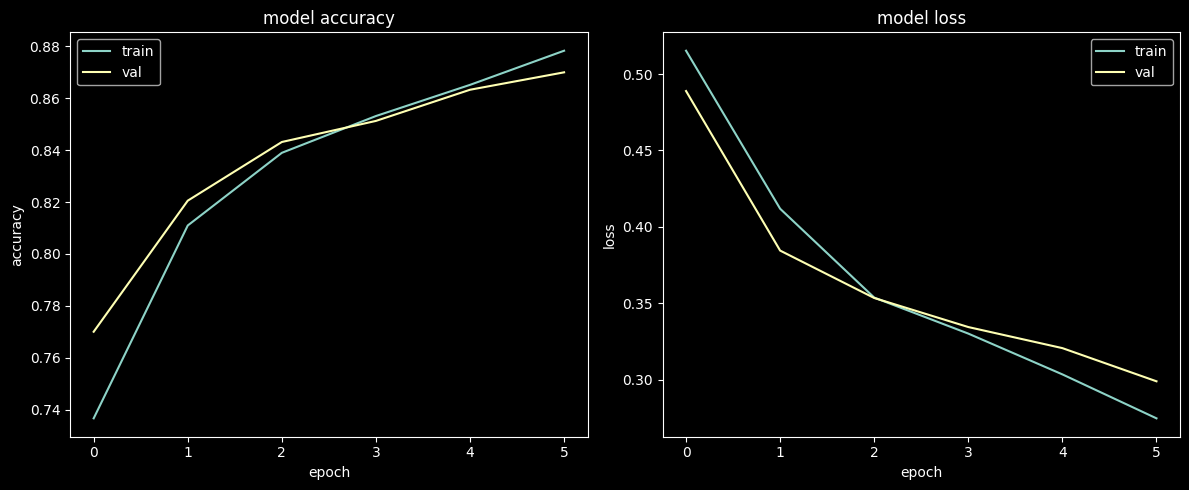

In [15]:
# Plot the loss and accuracy per epoch
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

ax[0].plot(lstm_model_1_history.history['acc'])
ax[0].plot(lstm_model_1_history.history['val_acc'])

ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train','val'], loc='upper left')

ax[1].plot(lstm_model_1_history.history['loss'])
ax[1].plot(lstm_model_1_history.history['val_loss'])

ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train','val'], loc='upper right')

plt.tight_layout()

In [16]:
# Classification report on test data
y_pred = lstm_model_1.predict(X_test)

print(classification_report(y_test, y_pred.round()))

380/380 [==============================] - 11s 28ms/step
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      6065
           1       0.86      0.88      0.87      6065

    accuracy                           0.87     12130
   macro avg       0.87      0.87      0.87     12130
weighted avg       0.87      0.87      0.87     12130



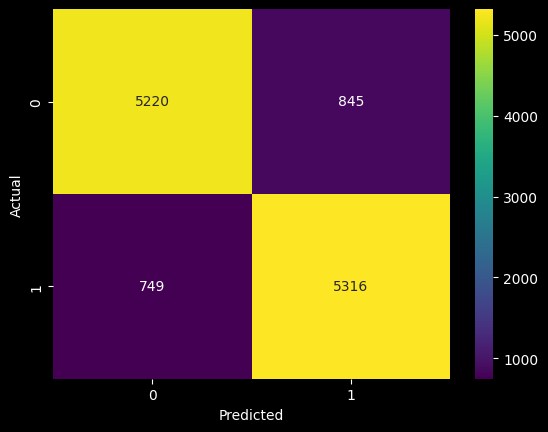

In [17]:
# Confusion matrix on the test set
sns.heatmap(confusion_matrix(y_test, y_pred.round()), annot=True, fmt='d', cmap='viridis')
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.show()

We get an accuracy of 87% from the LSTM model. The confusion matrix also show that the model is classifiying the classes well. We will tune the model by adding 1 more LSTM layer and see if we can improve the model further.

In [18]:
np.random.seed(42)

# Add 1 more layer to the original LSTM model
# Add 1 Dropout layer in between to aviod overfitting
lstm_model_2 = Sequential()
embedding_layer = Embedding(vocab_length, 300, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model_2.add(embedding_layer)
lstm_model_2.add(LSTM(128, return_sequences=True))
lstm_model_2.add(Dropout(0.5))
lstm_model_2.add(LSTM(64))
lstm_model_2.add(Dense(1, activation='sigmoid'))

In [19]:
# Compile the model
lstm_model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model_2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 60, 300)           8648700   
                                                                 
 lstm_1 (LSTM)               (None, 60, 128)           219648    
                                                                 
 dropout (Dropout)           (None, 60, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8917821 (34.02 MB)
Trainable params: 269121 (1.03 MB)
Non-trainable params: 8648700 (32.99 MB)
_________________________________________________________________
None


In [20]:
# Train the model
lstm_model_2_history = lstm_model_2.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
177/177 [==============================] - 52s 273ms/step - loss: 0.4950 - acc: 0.7511 - val_loss: 0.4069 - val_acc: 0.8135
Epoch 2/6
177/177 [==============================] - 47s 268ms/step - loss: 0.3899 - acc: 0.8241 - val_loss: 0.3775 - val_acc: 0.8239
Epoch 3/6
177/177 [==============================] - 46s 259ms/step - loss: 0.3397 - acc: 0.8471 - val_loss: 0.3251 - val_acc: 0.8525
Epoch 4/6
177/177 [==============================] - 45s 255ms/step - loss: 0.3014 - acc: 0.8656 - val_loss: 0.3399 - val_acc: 0.8507
Epoch 5/6
177/177 [==============================] - 47s 264ms/step - loss: 0.2701 - acc: 0.8835 - val_loss: 0.2991 - val_acc: 0.8654
Epoch 6/6
177/177 [==============================] - 32s 179ms/step - loss: 0.2464 - acc: 0.8931 - val_loss: 0.3242 - val_acc: 0.8695


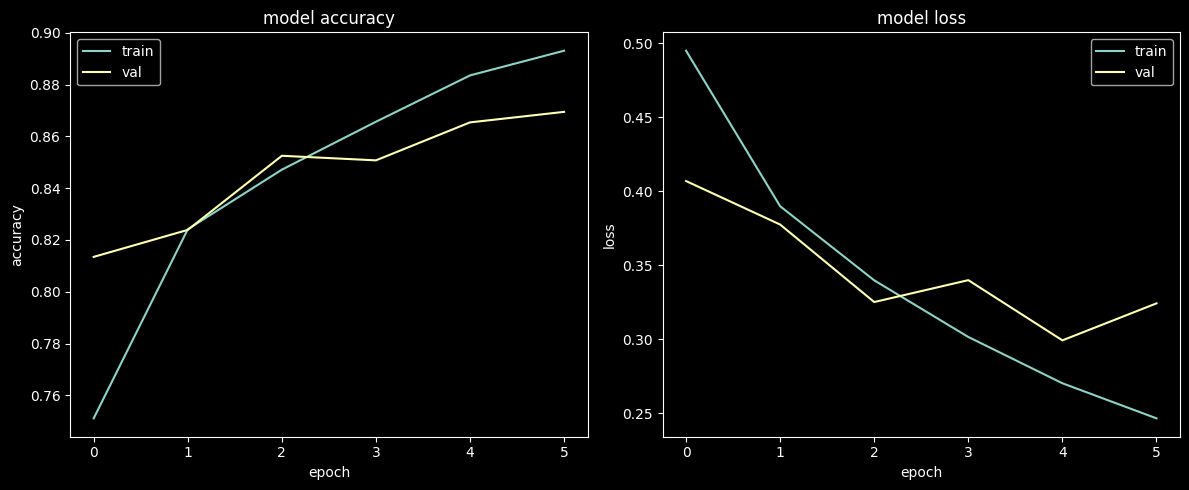

In [21]:
# Plot the loss and accuracy per epoch
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

ax[0].plot(lstm_model_2_history.history['acc'])
ax[0].plot(lstm_model_2_history.history['val_acc'])

ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train','val'], loc='upper left')

ax[1].plot(lstm_model_2_history.history['loss'])
ax[1].plot(lstm_model_2_history.history['val_loss'])

ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train','val'], loc='upper right')

plt.tight_layout()

In [22]:
# Classification report on test data
y_pred_1 = lstm_model_2.predict(X_test)

print(classification_report(y_test, y_pred_1.round()))

380/380 [==============================] - 8s 18ms/step
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      6065
           1       0.88      0.83      0.86      6065

    accuracy                           0.86     12130
   macro avg       0.86      0.86      0.86     12130
weighted avg       0.86      0.86      0.86     12130



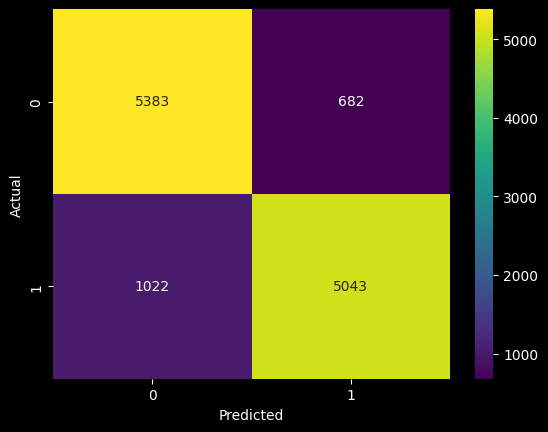

In [23]:
# Confusion matrix on the test set
sns.heatmap(confusion_matrix(y_test, y_pred_1.round()), annot=True, fmt='d', cmap='viridis');
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.show()

The accuracy on the test dataset decreases to 86%. We can see that the number of false negatives increased compared to the original LSTM model. This means that the model seems to have a slight bias towards fake reviews.

Other than accuracy, the original LSTM model have a slight edge over the second model due to a more balanced recall and precision. We will save the original LSTM model for future deployment if necessary.

In [24]:
# Save the tokenizer and model
# with open('embedding_tokenizer.pkl', 'wb') as f:
#     pickle.dump(em_word_tokenizer, f)

# with open('LSTM_model.pkl', 'wb') as f:
#     pickle.dump(lstm_model_1, f)